Using device: cuda

Training on Full MNIST Dataset
Epoch 1/5 - Loss: 0.3482, Accuracy: 90.36%
Epoch 2/5 - Loss: 0.1326, Accuracy: 96.02%
Epoch 3/5 - Loss: 0.0873, Accuracy: 97.36%
Epoch 4/5 - Loss: 0.0635, Accuracy: 98.02%
Epoch 5/5 - Loss: 0.0482, Accuracy: 98.46%

Baseline Test Accuracy: 97.82%

Computing Fisher Information Matrices...
----------------------------------------------------------------------
1. Computing Empirical Fisher (standard cross-entropy gradient)...
2. Computing True Fisher (log-likelihood with predicted class)...
3. Computing Sampled Fisher (log-likelihood with sampled class)...
Done computing Fisher matrices.

Testing Network Importance with Different Parameter Percentages

Method: Empirical Fisher
----------------------------------------------------------------------
    5% parameters kept -> Accuracy: 11.76%
   10% parameters kept -> Accuracy: 20.49%
   15% parameters kept -> Accuracy: 39.98%
   20% parameters kept -> Accuracy: 56.21%
   25% parameters kept 

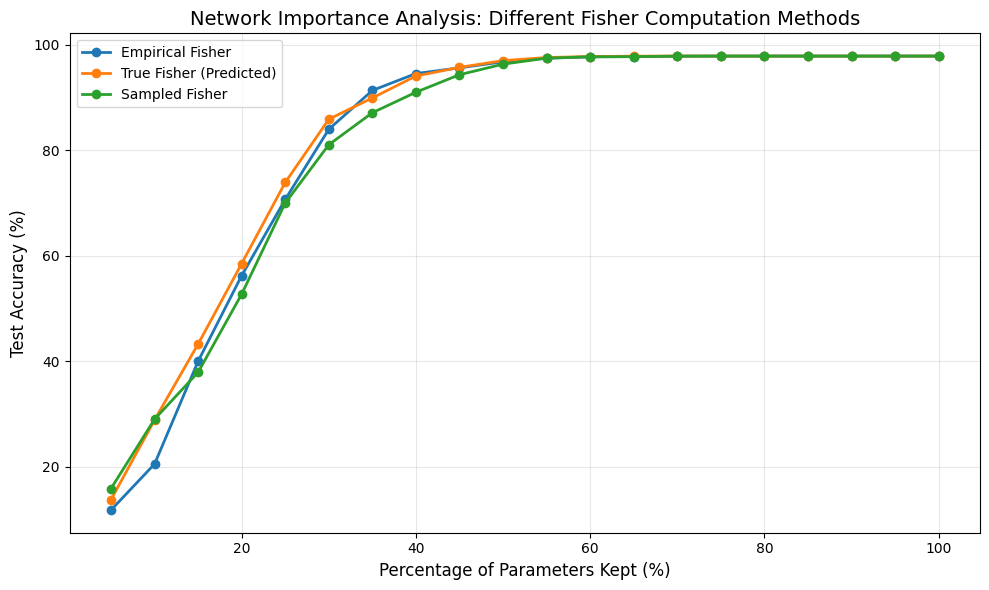


Summary Statistics

Empirical Fisher:
  Accuracy at 10% params: 20.49%
  Accuracy at 50% params: 96.74%
  Accuracy at 100% params: 97.82%
  Drop from 100% to 10%: 77.33%

True Fisher (Predicted):
  Accuracy at 10% params: 28.85%
  Accuracy at 50% params: 96.96%
  Accuracy at 100% params: 97.82%
  Drop from 100% to 10%: 68.97%

Sampled Fisher:
  Accuracy at 10% params: 28.98%
  Accuracy at 50% params: 96.29%
  Accuracy at 100% params: 97.82%
  Drop from 100% to 10%: 68.84%

Experiment completed!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from os.path import expanduser
import matplotlib.pyplot as plt
import os
import copy


def network_mnist(size_first_layer, size_second_layer):
    """Create MLP network for MNIST"""
    class MLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(784, size_first_layer)
            self.fc2 = nn.Linear(size_first_layer, size_second_layer)
            self.fc3 = nn.Linear(size_second_layer, 10)

        def forward(self, x):
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    return MLP()


def train_full_mnist(model, train_loader, epochs, criterion, optimizer, device):
    """Train on full MNIST dataset"""
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        accuracy = 100 * correct / total
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


def test_mnist(model, test_loader, device):
    """Test on MNIST dataset"""
    model.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    return accuracy


def compute_fisher_empirical(model, train_loader, num_samples, criterion, device):
    """
    Compute empirical Fisher Information Matrix using squared gradients
    of the cross-entropy loss (standard implementation).
    """
    model.eval()
    fisher_dict = {name: torch.zeros_like(param, device=device) 
                   for name, param in model.named_parameters()}
    
    count = 0
    for images, labels in train_loader:
        if count >= num_samples:
            break
        
        images, labels = images.to(device), labels.to(device)
        
        model.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Accumulate squared gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_dict[name] += param.grad.detach() ** 2
        
        count += images.size(0)
    
    # Average over samples
    for name in fisher_dict:
        fisher_dict[name] /= count
    
    return fisher_dict


def compute_fisher_true(model, train_loader, num_samples, device):
    """
    Compute "true" Fisher Information Matrix using log-likelihood
    and predicted class (not true class).
    """
    model.eval()
    fisher_dict = {name: torch.zeros_like(param, device=device) 
                   for name, param in model.named_parameters()}
    
    count = 0
    for images, labels in train_loader:
        if count >= num_samples:
            break
        
        images = images.to(device)
        batch_size = images.size(0)
        
        for i in range(batch_size):
            if count >= num_samples:
                break
            
            image = images[i:i+1]
            
            model.zero_grad()
            outputs = model(image)
            
            # Use log probabilities
            log_probs = F.log_softmax(outputs, dim=1)
            
            # Sample from the model's prediction (or use predicted class)
            predicted_class = torch.argmax(outputs, dim=1)
            loss = -log_probs[0, predicted_class]
            
            loss.backward()
            
            # Accumulate squared gradients
            for name, param in model.named_parameters():
                if param.grad is not None:
                    fisher_dict[name] += param.grad.detach() ** 2
            
            count += 1
    
    # Average over samples
    for name in fisher_dict:
        fisher_dict[name] /= count
    
    return fisher_dict


def compute_fisher_sampled(model, train_loader, num_samples, device):
    """
    Compute Fisher Information by sampling from model's distribution.
    Uses sampled class instead of predicted/true class.
    """
    model.eval()
    fisher_dict = {name: torch.zeros_like(param, device=device) 
                   for name, param in model.named_parameters()}
    
    count = 0
    for images, labels in train_loader:
        if count >= num_samples:
            break
        
        images = images.to(device)
        batch_size = images.size(0)
        
        for i in range(batch_size):
            if count >= num_samples:
                break
            
            image = images[i:i+1]
            
            model.zero_grad()
            outputs = model(image)
            
            # Sample from the model's output distribution
            probs = F.softmax(outputs, dim=1)
            sampled_class = torch.multinomial(probs, 1).squeeze()
            
            log_probs = F.log_softmax(outputs, dim=1)
            loss = -log_probs[0, sampled_class]
            
            loss.backward()
            
            # Accumulate squared gradients
            for name, param in model.named_parameters():
                if param.grad is not None:
                    fisher_dict[name] += param.grad.detach() ** 2
            
            count += 1
    
    # Average over samples
    for name in fisher_dict:
        fisher_dict[name] /= count
    
    return fisher_dict


def apply_importance_mask(model, fisher_dict, importance_percent):
    """
    Mask out (set to zero) the least important weights based on Fisher information.
    Keep only the top importance_percent% of weights.
    """
    # Flatten all Fisher values
    all_importances = []
    for name, fisher in fisher_dict.items():
        all_importances.append(fisher.flatten())
    
    all_importances = torch.cat(all_importances)
    
    # Determine threshold
    k = int(len(all_importances) * importance_percent / 100)
    threshold = torch.topk(all_importances, k).values[-1]
    
    # Create mask and apply
    mask_dict = {}
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in fisher_dict:
                mask = (fisher_dict[name] >= threshold).float()
                param.mul_(mask)
                mask_dict[name] = mask
    
    return model, mask_dict


def plot_importance_comparison(percent_list, results_dict, save_path='figures/fisher_comparison.pdf'):
    """Plot comparison of different Fisher computation methods"""
    plt.figure(figsize=(10, 6))
    
    for method_name, accuracy_list in results_dict.items():
        plt.plot(percent_list, accuracy_list, marker='o', linewidth=2, label=method_name)
    
    plt.xlabel('Percentage of Parameters Kept (%)', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title('Network Importance Analysis: Different Fisher Computation Methods', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved to {save_path}")
    plt.show()


def main():
    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")
    
    # Load full MNIST dataset
    mnist_train = MNIST(
        root=expanduser("~") + "/.avalanche/data/mnist/",
        train=True,
        download=True,
        transform=ToTensor(),
    )
    mnist_test = MNIST(
        root=expanduser("~") + "/.avalanche/data/mnist/",
        train=False,
        download=True,
        transform=ToTensor(),
    )
    
    train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)
    
    # Training parameters
    epochs = 5
    num_fisher_samples = 1000
    
    print("="*70)
    print("Training on Full MNIST Dataset")
    print("="*70)
    
    # Create and train model
    model = network_mnist(256, 128)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_full_mnist(model, train_loader, epochs, criterion, optimizer, device)
    
    # Test original model
    baseline_acc = test_mnist(model, test_loader, device)
    print(f"\n{'='*70}")
    print(f"Baseline Test Accuracy: {baseline_acc:.2f}%")
    print(f"{'='*70}\n")
    
    # Save model state for restoration
    original_state = copy.deepcopy(model.state_dict())
    
    # Compute Fisher Information using different methods
    print("Computing Fisher Information Matrices...")
    print("-"*70)
    
    print("1. Computing Empirical Fisher (standard cross-entropy gradient)...")
    fisher_empirical = compute_fisher_empirical(model, train_loader, num_fisher_samples, criterion, device)
    
    print("2. Computing True Fisher (log-likelihood with predicted class)...")
    fisher_true = compute_fisher_true(model, train_loader, num_fisher_samples, device)
    
    print("3. Computing Sampled Fisher (log-likelihood with sampled class)...")
    fisher_sampled = compute_fisher_sampled(model, train_loader, num_fisher_samples, device)
    
    print("Done computing Fisher matrices.\n")
    
    # Test with different percentages of parameters
    percent_list = list(range(5, 101, 5))  # 5%, 10%, ..., 100%
    results_dict = {
        'Empirical Fisher': [],
        'True Fisher (Predicted)': [],
        'Sampled Fisher': []
    }
    
    fisher_methods = {
        'Empirical Fisher': fisher_empirical,
        'True Fisher (Predicted)': fisher_true,
        'Sampled Fisher': fisher_sampled
    }
    
    print("="*70)
    print("Testing Network Importance with Different Parameter Percentages")
    print("="*70)
    
    for method_name, fisher_dict in fisher_methods.items():
        print(f"\nMethod: {method_name}")
        print("-"*70)
        
        for p in percent_list:
            # Restore original weights
            model.load_state_dict(original_state)
            
            # Apply importance mask
            model, mask_dict = apply_importance_mask(model, fisher_dict, importance_percent=p)
            
            # Test accuracy
            acc = test_mnist(model, test_loader, device)
            results_dict[method_name].append(acc)
            
            print(f"  {p:3d}% parameters kept -> Accuracy: {acc:.2f}%")
    
    # Plot comparison
    print("\n" + "="*70)
    print("Generating comparison plot...")
    plot_importance_comparison(percent_list, results_dict, save_path='figures/fisher_comparison.pdf')
    
    # Summary statistics
    print("\n" + "="*70)
    print("Summary Statistics")
    print("="*70)
    for method_name, accuracies in results_dict.items():
        print(f"\n{method_name}:")
        print(f"  Accuracy at 10% params: {accuracies[1]:.2f}%")
        print(f"  Accuracy at 50% params: {accuracies[9]:.2f}%")
        print(f"  Accuracy at 100% params: {accuracies[-1]:.2f}%")
        print(f"  Drop from 100% to 10%: {accuracies[-1] - accuracies[1]:.2f}%")
    
    print("\n" + "="*70)
    print("Experiment completed!")
    print("="*70)


if __name__ == "__main__":
    main()


In [1]:
print("Script executed successfully.")

Script executed successfully.
